In [ ]:
%pip install wordcloud

### 1. Data Collecting

Tahapan ini ada pada `scraping.ipynb` yang dimana kita mengambil dataset sejumlah 12.000 review dari google play store menggunakan `google-play-scraper`

### 2. Data Preprocessing

#### a. Data Info

In [37]:
from sklearn.model_selection import train_test_split
import tensorflow as tf
import pandas as pd
import seaborn as sns

In [2]:
df = pd.read_csv('./dataset/reviews.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   reviewId  12000 non-null  object
 1   userName  12000 non-null  object
 2   content   12000 non-null  object
 3   score     12000 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 375.1+ KB


#### b. Data Sample

In [36]:
df.head()

,reviewId,userName,content,score,sentiments
0,eeb31930-2431-428a-9f4e-baf93928cf94,Dzaki Abdullah Fawwaaz,"GAME NYA BAGUS BANGET, MULAI DARI STORY, EVENT...",5,1
1,cf26cb0f-e84c-4c0d-93a6-613f1fe34cec,Ajeng Rasti,Scaramouche.,5,1
2,d36cfcac-6ac9-40ff-ab44-f59b345e35fa,Yanti Baru,Yah pokoknya bagus deh Grafik bagus . Karakter...,5,1
3,b42f0cbb-da51-403d-b23a-10b571ff007e,Muh.fauzan Fausan,Grafik nya mantap pol tapi aku masih download ...,5,1
4,f2a1e9dd-e3d2-4b4b-ae0c-1d167f19a047,Rina Rahmawati,Game bagus,5,1


#### c. Data Sentiment

Di kita akan menambahkan kolom baru pada DataFrame yaitu `sentiments` untuk membagi kelompok dari review. 0 untuk `score <= 2` dan 1 untuk `score >= 3`

In [3]:
df['sentiments'] = df.score.apply(lambda x: 0 if x in [1, 2] else 1)

### 3. Data Analysis and Visualization

In [4]:
import matplotlib.pyplot as plt

#### a. Visualisasi terhadapat sentiment

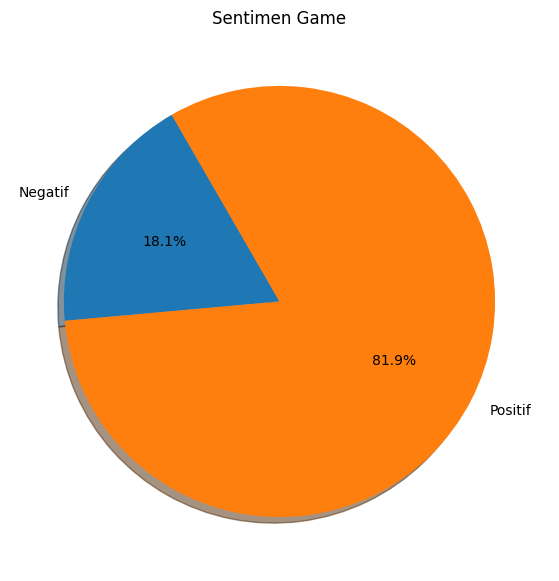

In [5]:
plt.figure(figsize=(15,7))
# sentimen = df.dropna(subset=['sentiments']).sort_values(by=['sentiments'])['sentiments'].unique()
total = df.groupby(['sentiments'])['score'].count()
plt.pie(total, labels=(["Negatif", "Positif"]), autopct='%.1f%%', startangle = 120, shadow = True)
plt.title('Sentimen Game')
plt.show()


#### b. Visualisasi Terhadap Rating

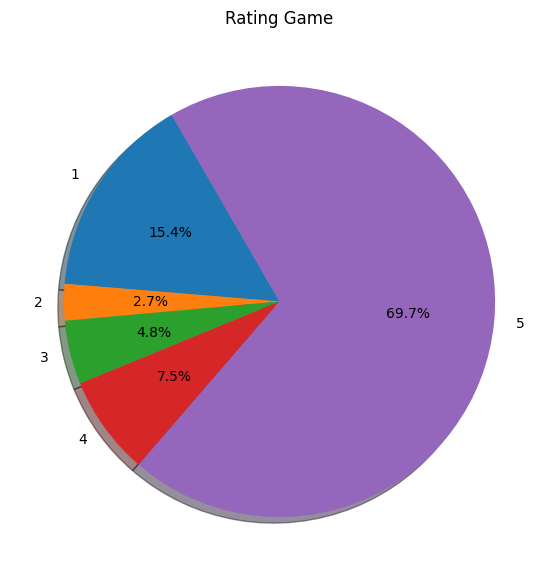

In [6]:
plt.figure(figsize=(15,7))
rating = df.dropna(subset=['score']).sort_values(by=['score'])['score'].unique()
total = df.groupby(['score'])['reviewId'].count()
plt.pie(total, labels=rating, autopct='%.1f%%', startangle = 120, shadow = True)
plt.title('Rating Game')
plt.show()


#### c. Visualisasi Kata ter Banyak dengan Word Cloud

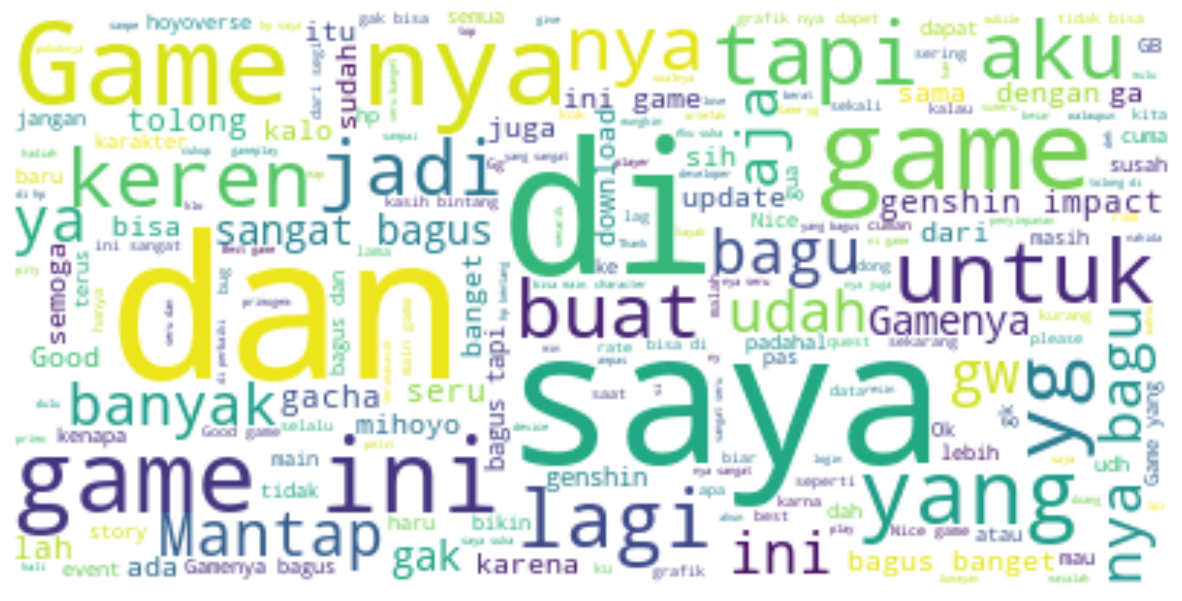

In [7]:
from wordcloud import WordCloud
from wordcloud import ImageColorGenerator
from wordcloud import STOPWORDS
import matplotlib.pyplot as plt
import pandas as pd


text = " ".join(i for i in df.content)
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)
plt.figure( figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### 4. Data Modeling

In [41]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
tokenizer = Tokenizer(oov_token="<OOV>")

In [40]:
x_train, x_test, y_train, y_test = train_test_split(df['content'], df['sentiments'], test_size=0.4, shuffle=True)


In [43]:
import numpy as np
training_sentences = []
training_labels = []
testing_sentences = []
testing_labels = []
for row in x_train:
    training_sentences.append(str(row))
for row in y_train:
    training_labels.append(row)
for row in x_test:
    testing_sentences.append(str(row))
for row in y_test:
    testing_labels.append(row)


In [44]:
vocab_size = 40000
embedding_dim = 16
max_length = 120
trunc_type = 'post'
oov_tok = '<OOV>'
padding_type = 'post'

In [45]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index

word_index 


{'<OOV>': 1,
 'game': 2,
 'bagus': 3,
 'nya': 4,
 'di': 5,
 'saya': 6,
 'ini': 7,
 'dan': 8,
 'yang': 9,
 'bisa': 10,
 'tapi': 11,
 'sangat': 12,
 'untuk': 13,
 'banget': 14,
 'seru': 15,
 'main': 16,
 'hp': 17,
 'tolong': 18,
 'yg': 19,
 'tidak': 20,
 'gamenya': 21,
 'ada': 22,
 'aku': 23,
 'keren': 24,
 'lagi': 25,
 'buat': 26,
 'genshin': 27,
 'gak': 28,
 'update': 29,
 'the': 30,
 'banyak': 31,
 'good': 32,
 'grafik': 33,
 'dari': 34,
 'juga': 35,
 'kasih': 36,
 'aja': 37,
 'udah': 38,
 'suka': 39,
 'download': 40,
 'gw': 41,
 'i': 42,
 'ga': 43,
 'ya': 44,
 'jadi': 45,
 'gacha': 46,
 'mantap': 47,
 'bintang': 48,
 'karakter': 49,
 'lah': 50,
 'sudah': 51,
 'mau': 52,
 'sih': 53,
 'kalo': 54,
 'sama': 55,
 'itu': 56,
 '1': 57,
 'dengan': 58,
 'impact': 59,
 'lebih': 60,
 'karena': 61,
 '5': 62,
 'padahal': 63,
 'nice': 64,
 'lama': 65,
 'cuma': 66,
 'gk': 67,
 'terlalu': 68,
 'masih': 69,
 'data': 70,
 'story': 71,
 'ke': 72,
 '3': 73,
 'hoyoverse': 74,
 'bikin': 75,
 'is': 76,
 's

In [46]:
sequences = tokenizer.texts_to_sequences(training_sentences)
padded = pad_sequences(sequences, maxlen=max_length, truncating=trunc_type)
testing_sentences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sentences, maxlen=max_length)

In [47]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim,       input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [48]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [49]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 120, 16)           640000    
                                                                 
 global_average_pooling1d_4   (None, 16)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_11 (Dense)            (None, 6)                 102       
                                                                 
 dense_12 (Dense)            (None, 1)                 7         
                                                                 
Total params: 640,109
Trainable params: 640,109
Non-trainable params: 0
_________________________________________________________________


In [50]:
training_labels_final = np.array(training_labels)
testing_labels_final = np.array(testing_labels)
testing_labels_final

array([1, 1, 1, ..., 0, 1, 1])

In [51]:
num_epochs = 20
history = model.fit(padded, training_labels_final, epochs=num_epochs, validation_data=(testing_padded, testing_labels_final))

Epoch 1/20
225/225 [==============================] - 4s 13ms/step - loss: 0.5367 - accuracy: 0.8139 - val_loss: 0.4529 - val_accuracy: 0.8269
Epoch 2/20
225/225 [==============================] - 3s 12ms/step - loss: 0.4688 - accuracy: 0.8139 - val_loss: 0.4492 - val_accuracy: 0.8269
Epoch 3/20
225/225 [==============================] - 2s 11ms/step - loss: 0.4640 - accuracy: 0.8139 - val_loss: 0.4463 - val_accuracy: 0.8269
Epoch 4/20
225/225 [==============================] - 2s 10ms/step - loss: 0.4582 - accuracy: 0.8139 - val_loss: 0.4422 - val_accuracy: 0.8269
Epoch 5/20
225/225 [==============================] - 2s 10ms/step - loss: 0.4511 - accuracy: 0.8140 - val_loss: 0.4367 - val_accuracy: 0.8273
Epoch 6/20
225/225 [==============================] - 2s 10ms/step - loss: 0.4391 - accuracy: 0.8174 - val_loss: 0.4259 - val_accuracy: 0.8258
Epoch 7/20
225/225 [==============================] - 2s 10ms/step - loss: 0.4171 - accuracy: 0.8224 - val_loss: 0.4144 - val_accuracy: 0.8267

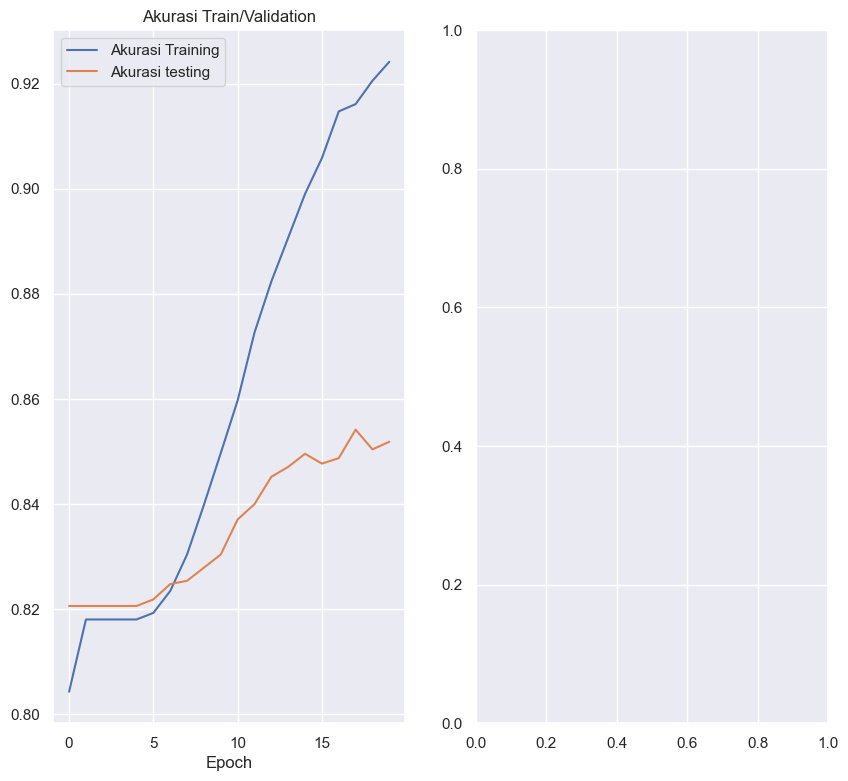

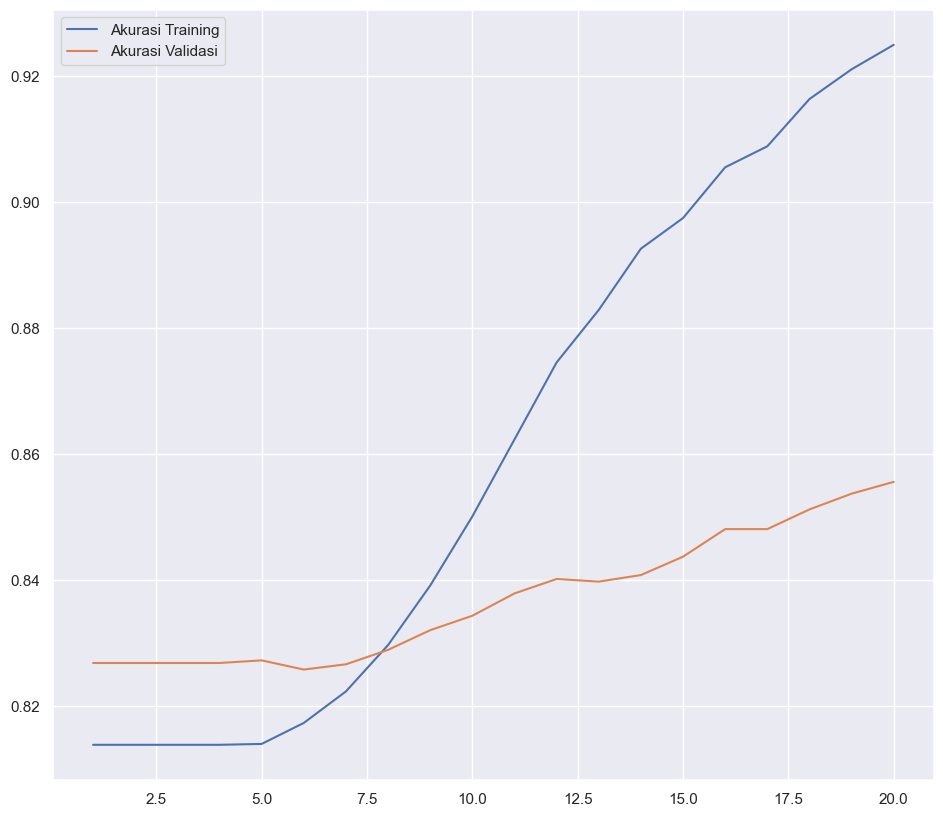

In [52]:
epochs = [i+1 for i in range(20)]

sns.set_theme()

plt.figure(figsize=(25,10))

plt.subplot(1,2,1)
sns.lineplot(x=epochs, y=history.history['accuracy'], label='Akurasi Training')
sns.lineplot(x=epochs, y=history.history['val_accuracy'], label='Akurasi Validasi')

In [53]:
predict_sentences = tokenizer.texts_to_sequences(["Artefak Kebenyakan Susah untuk menyesuaikanya dengan Milik kita karena gak Sesuai, jadi disini saya Berharap ada fitur Barter Artefak atau Senjata B4 yang Mungkin Orang Gak Menginginkanya Bisa Ditukarkan di Fitur Barter Ini, Jadi Pihak setuju pasti akan Mengambilnya kalo Butuh, Mohon di baca Saran Saya"])
predict_padded = pad_sequences(predict_sentences, maxlen=max_length)

model.predict(predict_padded)

1/1 [==============================] - 0s 69ms/step


array([[0.8978639]], dtype=float32)